Import the relevant classes and libraries.

In [1]:
import matplotlib.pyplot as plt
import nsidc_dataviewer_utils as utils
import numpy as np
from datetime import datetime, timedelta
from matplotlib import animation
from IPython.display import HTML

## Variables

Here's where all of your config happens. Change these variables to change how the animation looks and how fast it goes.

This is a list of all of the different places where data can be accessed from. Change the number in `CURRENT_SOURCE` to point to a different location.

In [2]:
utils.pretty_print_sources("0046")

NSIDC_0046_FORMAT = /projects/DATASETS/nsidc0046_weekly_snow_seaice/data/EASE2_N25km.snowice.{syymmdd}-{eyymmdd}.v04.bin

NSIDC_0046_STAGING_FORMAT = /disks/sidads_staging/DATASETS/nsidc0046_weekly_snow_seaice/data/EASE2_N25km.snowice.{syymmdd}-{eyymmdd}.v04.bin

NSIDC_0046_BROWSE_STAGING_FORMAT = /disks/sidads_staging/DATASETS/nsidc0046_weekly_snow_seaice/browse/EASE2_N25km.snowice.{syymmdd}-{eyymmdd}.v04.png



In [3]:
SOURCES = utils.get_sources("0046")
CURRENT_SOURCE = SOURCES[0]
print(CURRENT_SOURCE)

/projects/DATASETS/nsidc0046_weekly_snow_seaice/data/EASE2_N25km.snowice.{syymmdd}-{eyymmdd}.v04.bin


This is the start date and end date for the animation. The script will skip over files that don't exist. Make sure that the start date points to a file with that start date- otherwise the script will loop on the wrong days and it won't find any of the correct files.

In [4]:
TIMEFRAME = (datetime(2013, 1, 7), datetime(2013, 6, 10))

This is the framerate for the animation. `interval` refers to the time between frames, in MS. 50-100 is recommended.

In [5]:
INTERVAL = 50

These parameters refer to the width and height of the rendered animation. Larger animation means longer render times.

In [6]:
ANIMATION_WIDTH = 5
ANIMATION_HEIGHT = 5

Finally, use this variable to toggle log messages. (True/False, case sensitive)

In [7]:
VERBOSE = True

These are some configs and helper methods.

Rendering data for 2013-01-07 00:00:00
Rendering data for 2013-01-07 00:00:00
Rendering data for 2013-01-14 00:00:00
Rendering data for 2013-01-21 00:00:00
Rendering data for 2013-01-28 00:00:00
Rendering data for 2013-02-04 00:00:00
Rendering data for 2013-02-11 00:00:00
Rendering data for 2013-02-18 00:00:00
Rendering data for 2013-02-25 00:00:00
Rendering data for 2013-03-04 00:00:00
Rendering data for 2013-03-11 00:00:00
Rendering data for 2013-03-18 00:00:00
Rendering data for 2013-03-25 00:00:00
Rendering data for 2013-04-01 00:00:00
Rendering data for 2013-04-08 00:00:00
Rendering data for 2013-04-15 00:00:00
Rendering data for 2013-04-22 00:00:00
Rendering data for 2013-04-29 00:00:00
Rendering data for 2013-05-06 00:00:00
Rendering data for 2013-05-13 00:00:00
Rendering data for 2013-05-20 00:00:00
Rendering data for 2013-05-27 00:00:00
Rendering data for 2013-06-03 00:00:00
=> elasped render: 10.56994104385376 s
Rendering data for 2013-01-07 00:00:00


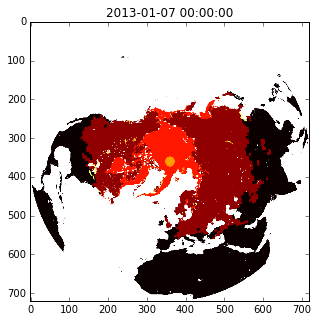

In [8]:
%matplotlib inline

plt.rcParams['animation.writer']= 'avconv'

def setup():
    global dsl
    dates_array = utils.generate_dates_array(TIMEFRAME, week=True)
    dsl = len(dates_array)
    PNG = False
    if "browse" in CURRENT_SOURCE:
        PNG = True
        print("Rendering PNG")
    dataset_shape = (720, 720)
    constants_dict = {'cs':CURRENT_SOURCE,
                      'da':dates_array,
                      'ds':dataset_shape,
                      'v':VERBOSE,
                      'sb':5,
                      'p':plt,
                      'png':PNG,
                      'rng':True,
                      'cc':"hot"}
    utils.const.set_constants(**constants_dict)
    
setup()

fig = plt.figure(figsize=(ANIMATION_WIDTH, ANIMATION_HEIGHT))
anim = animation.FuncAnimation(fig, 
                               utils.render, 
                               frames=dsl, 
                               interval=INTERVAL, 
                               repeat=True)
HTML(anim.to_html5_video())